In [1]:
from numba import njit, prange
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import xarray as xr

In [2]:
from affine import identity as IDENTITY

@njit
def degree_metres_y(lat):
    """ "returns the verical length of a degree in metres at
    a given latitude."""
    m1 = 111132.92  # latitude calculation term 1
    m2 = -559.82  # latitude calculation term 2
    m3 = 1.175  # latitude calculation term 3
    m4 = -0.0023  # latitude calculation term 4
    # # Calculate the length of a degree of latitude and longitude in meters
    radlat = np.radians(lat)
    latlen = (
        m1
        + (m2 * np.cos(2.0 * radlat))
        + (m3 * np.cos(4.0 * radlat))
        + (m4 * np.cos(6.0 * radlat))
    )
    return latlen


@njit
def degree_metres_x(lat):
    """ "returns the horizontal length of a degree in metres at
    a given latitude."""
    p1 = 111412.84  # longitude calculation term 1
    p2 = -93.5  # longitude calculation term 2
    p3 = 0.118  # longitude calculation term 3
    # # Calculate the length of a degree of latitude and longitude in meters
    radlat = np.radians(lat)
    longlen = (
        (p1 * np.cos(radlat))
        + (p2 * np.cos(3.0 * radlat))
        + (p3 * np.cos(5.0 * radlat))
    )
    return longlen

In [3]:
@njit(parallel=True)
def spread2d(obs, msk, frc, latlon=False, transform=IDENTITY):
    nrow, ncol = obs.shape
    xres, yres, north = transform[0], transform[4], transform[5]
    dx, dy = xres, yres
    
    out = obs.copy()
    src = np.full(obs.shape, -1, dtype=np.int32)   # linear index of source
    dst = np.full(obs.shape, -1, dtype=np.float32) # distance from source
    nxt = obs > 0    
    nxt1 = nxt.copy()
    
    for r, c in zip(*np.where(nxt)):
        src[r, c] = r*ncol+c
        dst[r, c] = 0
        
    while np.any(nxt):
        for  r in prange(nrow):
            for c in prange(ncol):
                if nxt[r, c]:
                    nxt1[r, c] = False
                    i0 = src[r, c]
                    d0 = dst[r, c]
                    f0 = frc[r, c]
                    if latlon:
                        lat = north + (r + 0.5) * yres
                        dy = degree_metres_y(lat)*yres
                        dx = degree_metres_x(lat)*xres
                    for dr in range(-1,2):
                        for dc in range(-1,2):
                            if dr == 0 and dc == 0:
                                continue
                            r1, c1 = r+dr, c+dc
                            if r1 < 0 or r1 >= nrow or c1 < 0 or c1 >= ncol or msk[r1,c1] != 1:
                                continue
                            dd = np.hypot(dx*dr, dy*dc)
                            d = d0 + dd*f0
                            if src[r1, c1] == -1 or d < dst[r1, c1]:
                                src[r1, c1] = i0
                                dst[r1, c1] = d
                                out[r1, c1] = obs.flat[i0]
                                nxt1[r1, c1] = True
        nxt = nxt1.copy()
    return out, src, dst
                        
def spread2d_pnts(rs, cs, zs, msk, frc=None, nodata=0, latlon=False, transform=IDENTITY):
    
    z = np.full(msk.shape, nodata, dtype=zs.dtype)
    z[rs, cs] = zs
    
    if frc is None:
        frc = np.ones_like(msk, dtype=np.float32)
    
    return spread2d(z, msk!=0, frc, latlon=latlon, transform=transform)

Text(0.5, 1.0, 'distance to source')

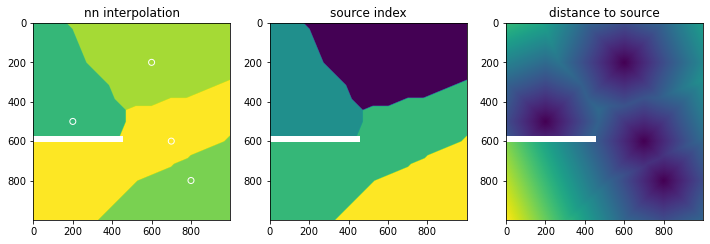

In [23]:
# test spread algorithm
rs = np.array([5, 2, 6, 8])[:4]*100
cs = np.array([2, 6, 7, 8])[:4]*100
zs = np.array([1, 1.3, 1.5, 1.2])[:4]

msk = np.ones((1000, 1000), dtype=np.bool)
msk[580:600, :450] = False

# plot 
nodata =-9999
out, src, dst = spread2d_pnts(rs, cs, zs, msk, nodata=nodata)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,5))
ax1.imshow(np.ma.masked_equal(out,nodata), vmin=0, vmax=zs.max())
ax1.scatter(cs, rs, c=zs, vmin=0, vmax=zs.max(), edgecolor='w')
ax1.set_title('nn interpolation')
ax2.imshow(np.ma.masked_equal(src,-1))
ax2.set_title('source index')
ax3.imshow(np.ma.masked_equal(dst,-1))
ax3.set_title('distance to source')

In [24]:
%time _ = spread2d_pnts(rs, cs, zs, msk, nodata=0)

Wall time: 1.41 s


In [25]:
from scipy.ndimage import binary_erosion
import pandas as pd
import rasterio

@njit(parallel=True, nogil=True)
def flood2d(h_ini, msl_ini, elv, msk, frc, latlon=False, transform=IDENTITY):
    nrow, ncol = h_ini.shape
    xres, yres, north = transform[0], transform[4], transform[5]
    dx, dy = xres, yres
    h_out = h_ini.copy()
    h_msl = msl_ini.copy()
    nxt = h_ini > 0
    nxt1 = nxt.copy()

    while np.any(nxt):
        for r in prange(nrow):
            for c in prange(ncol):
                if nxt[r, c]:
                    nxt1[r, c] = False
                    h0 = h_out[r, c]
                    msl0 = h_msl[r, c]
                    f0 = frc[r, c]
                    b0 = elv[r, c]                    
                    if latlon:
                        lat = north + (r + 0.5) * yres
                        dy = degree_metres_y(lat)*yres
                        dx = degree_metres_x(lat)*xres                      
                    for dr in range(-1,2):
                        for dc in range(-1,2):
                            if dr == 0 and dc == 0:
                                continue
                            r1, c1 = r+dr, c+dc
                            if r1 < 0 or r1 >= nrow or c1 < 0 or c1 >= ncol or msk[r1,c1] != 1:
                                continue
                            b1 = elv[r1, c1] 
                            z1 = b1 + h_out[r1, c1]
                            if msl0 > 0 and (b0 + msl0) > b1:
                                h1 = h0
                                h_msl[r1, c1] = max(b0 + msl0 - b1, 0)
                            else:
                                h1 = h0 - np.hypot(dx*dr, dy*dc) * f0
                            if h1 > 0 and (b0 + h1) > z1:
                                h_out[r1, c1] = max(b0 + h1 - b1, 0)
                                nxt1[r1, c1] = True
        nxt = nxt1.copy()
    return h_out, h_msl

def coastal_flood2d(df_pnts, elv, frc=None, nodata=-9999, latlon=False, transform=IDENTITY):
    
    # df_pnts should contain 'x', 'y', 'msl' and 'surge' columns
    df = df_pnts.copy()
    rs, cs = rasterio.transform.rowcol(transform, df['x'], df['y'])
    rows, cols = np.asarray(rs), np.asarray(cs)
    msl, surge = df['msl'].values, df['surge'].values
    df['idx'] = np.asarray(rows) * elv.shape[1] + np.asarray(cols)
    df = df.drop_duplicates('idx').set_index('idx')

    # interpolate point data to coastline
    msk = elv != nodata
    msk1 = ~binary_erosion(msk.copy(), np.ones((3,3)), border_value=1)
    ztot0, src, _ = spread2d_pnts(rows, cols, msl+surge, msk1, nodata=0, latlon=latlon, transform=transform)
    
    # calculate permanent inundataion and adapt friction based on it
    h_msl0 = np.where(msk, 0, nodata)
    if frc is None:
        frc = np.zeros_like(elv)   
    elif np.any(msl>0) and np.any(frc>0):
        frc0 = np.zeros_like(elv)
        z_msl0 = np.zeros_like(ztot0)
#         import pdb; pdb.set_trace()
        z_msl0[src!=-1] = df.loc[src[src!=-1], 'msl'].values
        h_msl0 = np.where(np.logical_and(z_msl0>elv, msk), z_msl0-elv, 0)
        h_msl0[~msk] = nodata
    
    # calculate initial water depth at coastline
    h0 = np.where(np.logical_and(ztot0>elv, msk), ztot0-elv, 0)
    h0[~msk] = nodata
    # bathtub with friction flooding
    msk2 = ztot0 == 0 # start inundation on land cells beyond coastline
    h, h_msl = flood2d(h0, h_msl0, elv, msk2, frc, latlon=latlon, transform=transform)
    return h, h_msl, h0, ztot0

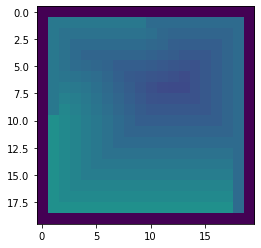

In [26]:
# simple test
nodata = -9999

df = pd.DataFrame()
df['x'] = np.array([0, 0, 19])+.5
df['y'] = np.array([0, 19, 0])+.5
df['surge'] = np.array([1.3, 1.5, 1.2])
df['msl'] = 0.5

elv = np.ones((20,20))
msk1 = binary_erosion(elv)
elv[~msk1] = nodata
frc = np.ones_like(elv)*0.05

h, h_msl, h0, ztot0 = coastal_flood2d(df, elv, frc, nodata)
plt.imshow(h, vmin=0., vmax=2)

(324, 341)


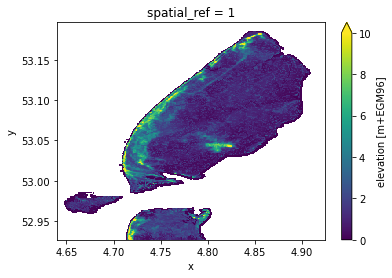

In [47]:
import hydromt
# da_elv = hydromt.get_rasterdataset('hydro_merit', bbox=[88.0,21.0,91.0,24.0])['elevtn']
# da_elv.rio.to_raster('MERIT_hydro_Bangladesh.tif')

# wall time tests on Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz, 2712 Mhz, 2 Core(s), 4 Logical Processor(s)


da_elv = hydromt.open_raster('MERIT_hydro_Texel.tif')
df = pd.DataFrame(columns=['x', 'y' , 'surge'], data = [[4.8, 52.97, 1.5], [4.75, 53.12,1.0], [4.9, 53.05,1.4]])
# shape (324, 341)
# Wall time: 144 ms

# da_elv = hydromt.open_raster('MERIT_hydro_Venice.tif')
# df = pd.DataFrame(columns=['x', 'y' , 'surge'], data = np.array([[12.5, 13, 13.5], [45.2, 45.5, 45.2], [1.1, 1.2, 1.4]]).T)
# shape (1575, 2551)
# Wall time: 13 s

# da_elv = hydromt.open_raster('MERIT_hydro_Bangladesh.tif')
# df = pd.DataFrame(columns=['x', 'y' , 'surge'], data = np.array([[88.5, 89.5, 90.5], [21.5, 21.5, 21.5], [1.1, 1.2, 1.4]]).T)
# shape (3600, 3600)
# Wall time: 4min 41s

da_elv.name = 'elv'
da_elv.attrs.update(long_name='elevation', units='m+EGM96')
ds = da_elv.to_dataset()

nodata = da_elv.rio.nodata
elv = da_elv.values
transform=da_elv.rio.transform
frc = np.ones_like(elv)*0.0005 # 50 cm / km

print(da_elv.shape)
da_elv.where(da_elv!=da_elv.rio.nodata).plot(vmax=10)

In [48]:
df['msl'] = 0.2
df.head()

,x,y,surge,msl
0,4.80,52.97,1.5,0.2
1,4.75,53.12,1.0,0.2
2,4.90,53.05,1.4,0.2


In [49]:
%time _ = coastal_flood2d(df, elv, frc, nodata=nodata, latlon=True, transform=transform)

Wall time: 121 ms


In [50]:
h, h_msl, h0, ztot0 = coastal_flood2d(df, elv, frc, nodata=nodata, latlon=True, transform=transform)

ds['obs'] = xr.Variable(ds.rio.dims, ztot0)
ds['obs'].attrs.update(long_name='interpolated water levels', units='m+EGM96', _FillValue=nodata)

ds['h_msl'] = xr.Variable(ds.rio.dims, h_msl)
ds['h_msl'].attrs.update(long_name='permanent inundation', units='m', _FillValue=nodata)

ds['h0'] = xr.Variable(ds.rio.dims, h0)
ds['h0'].attrs.update(long_name='initial water depth', units='m', _FillValue=nodata)

ds['h'] = xr.Variable(ds.rio.dims, h)
ds['h'].attrs.update(long_name='final inundation', units='m', _FillValue=nodata)

Text(0.5, 1.0, 'step 2. set boundary conditions \n (total water level)')

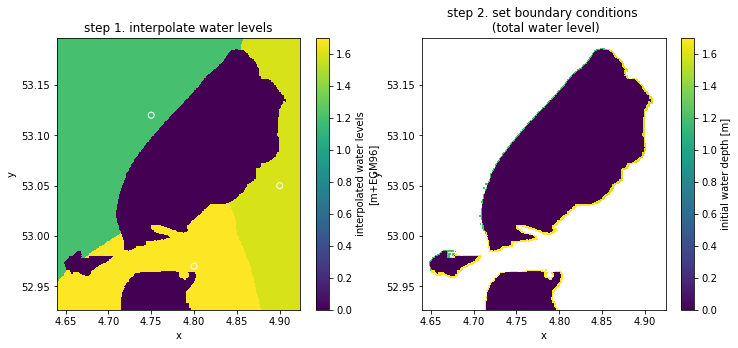

In [53]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
ds['obs'].where(ds['obs']!=nodata).plot(ax=axes[0])
axes[0].scatter(df['x'], df['y'], c=df['surge']+df['msl'], edgecolor='w', vmin=0)
axes[0].set_title('step 1. interpolate water levels')
ds['h0'].where(ds['h0']!=nodata).plot(ax=axes[1])
axes[1].set_title('step 2. set boundary conditions \n (total water level)')

Text(0.5, 1.0, 'step 3b. inundation depth \n(surge driven w/ resistance)')

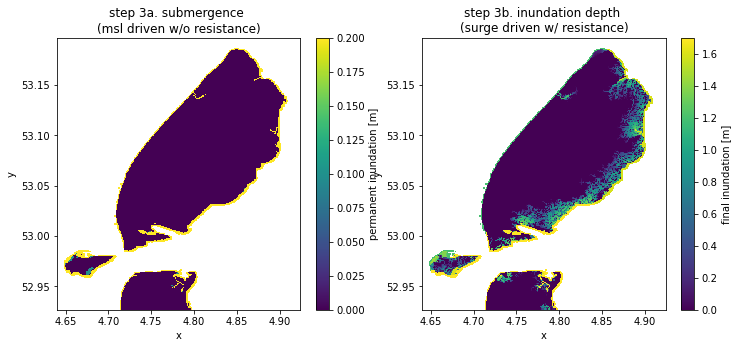

In [54]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
ds['h_msl'].where(ds['h_msl']!=nodata).plot(vmin=0, vmax=ds['h_msl'].max(), ax=axes[0])
axes[0].set_title('step 3a. submergence \n(msl driven w/o resistance)')
ds['h'].where(ds['h']!=nodata).plot(ax=axes[1])
axes[1].set_title('step 3b. inundation depth \n(surge driven w/ resistance)')